In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

We have chosen a [dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download) from Kaggle for predicting stroke. In our dataset, we have variable for whether a patient underwent a stroke, as well as other patient information such as BMI, sugar glucose level and others

The business value of predicting stroke is that we can select patients, who are at risk of stroke, and refer them to a specialist before they catch it. Because we have machine learning models at our disposal, we can create predictions faster than a specialist (though a specialist may be more accurate with their diagnosis).

Our target attribute will therefore be the stroke variable, telling us whether the person had a stroke or not. The instance of interest will be the person with id=69. In the unsupervised models we will be focusing on the residence type. The subset of our interest will be people who live in urban areas. The cost of a false negative is 5, cost of false positive is 1 and cost of true positive´s and negative´s is 0.

# Loading the data

In [170]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv").set_index("id")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [171]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


# Train-test split

We split the data into training set and test set to avoid any data leakage.

In [172]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["stroke"]
)

Let's see if these sets have similar characteristics.

In [173]:
train_set.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4088.000000,4088.000000,4088.000000,4088.000000,3918.000000,4088.000000
mean,43.353288,0.097114,0.054061,106.317167,28.922180,0.048679
std,22.596816,0.296148,0.226165,45.259652,7.928378,0.215223
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.312500,23.600000,0.000000
50%,45.000000,0.000000,0.000000,91.945000,28.000000,0.000000
75%,61.000000,0.000000,0.000000,114.197500,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [174]:
test_set.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,1022.000000,1022.000000,1022.000000,1022.000000,991.000000,1022.000000
mean,42.719922,0.098826,0.053816,105.469716,28.778809,0.048924
std,22.679867,0.298574,0.225765,45.394925,7.555922,0.215814
min,0.080000,0.000000,0.000000,55.260000,12.300000,0.000000
25%,24.000000,0.000000,0.000000,77.050000,23.400000,0.000000
50%,43.000000,0.000000,0.000000,91.605000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.715000,32.900000,0.000000
max,82.000000,1.000000,1.000000,267.610000,58.100000,1.000000


The distribution of the data seems fairly similar, we can probably proceed with further analysis.

# Outlier removal from train set

We will do an outlier analysis first
Looking at the columns, we can expect outliers in the:
* age column (very low and very high age)
* hypertension (most people don't have it)
* heart disease (most people don't have it)
* avg glucose level (some people have abnormally high/low values)
* bmi (a bmi of 10 is abnormally low, similarly a bmi of 97 is hardly believable)

In [175]:
train_set[["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]].describe()

,gender,ever_married,work_type,Residence_type,smoking_status
count,4088,4088,4088,4088,4088
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2395,2700,2332,2069,1501


We will have to examine these categorical variables separately

# Missing values

<Axes: ylabel='id'>

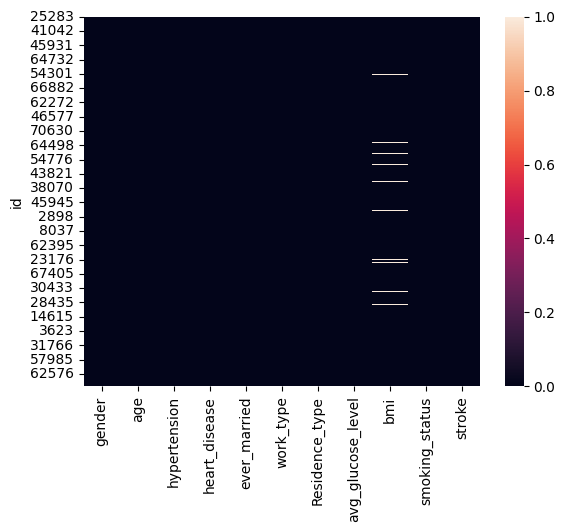

In [176]:
sns.heatmap(
    train_set.isna()
)

In [177]:
train_set.isna().sum().sort_values(ascending=False)

bmi                  170
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64

We have a few missing values of bmi.

Let's see if they are missing-at-random or missing-not-at-random

In [178]:
train_set.loc[~train_set["bmi"].isna()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,42.920429,0.091373,0.049260,105.455365,28.922180,0.041348
std,22.515845,0.288176,0.216438,44.338262,7.928378,0.199118
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.167500,23.600000,0.000000
50%,45.000000,0.000000,0.000000,91.815000,28.000000,0.000000
75%,60.000000,0.000000,0.000000,113.647500,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [179]:
train_set.loc[train_set["bmi"].isna()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,170.000000,170.000000,170.000000,170.000000,0.0,170.000000
mean,53.329412,0.229412,0.164706,126.179176,NaN,0.217647
std,22.222606,0.421697,0.372011,59.665040,NaN,0.413865
min,0.480000,0.000000,0.000000,57.920000,NaN,0.000000
25%,38.250000,0.000000,0.000000,79.837500,NaN,0.000000
50%,59.000000,0.000000,0.000000,98.985000,NaN,0.000000
75%,72.000000,0.000000,0.000000,191.630000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


It seems like respondents with missing bmi have different characteristics than the main group.

We should probably try to impute bmi values using a predictor.

In [180]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = train_set.loc[~train_set["bmi"].isna()].reset_index(drop=True).copy()
X["gender"] = X["gender"].apply(lambda x: x=="Male")
X["ever_married"] = X["ever_married"].apply(lambda x: x=="Yes")
X["smoking_status"] = X["smoking_status"].map({"never smoked": 0, "formerly smoked": 1, "smokes": 2, "Unknown": 0})
X = pd.get_dummies(
    data=X, columns=["work_type", "Residence_type"]
)
y = X.pop("bmi")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [181]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

train_rmse_list = []
test_rmse_list = []
search_space = [5, 10, 20, 30, 50, 75, 100]

for n_neighbors in search_space:
    print(
        "N-neighbors is set to:", n_neighbors, "neighbors"
    )
    reg = KNeighborsRegressor(
        n_neighbors=n_neighbors
    )
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    train_pred = reg.predict(X_train)
    train_rmse = round(
            np.sqrt(
                mean_squared_error(y_train, train_pred)
            ), 2
        )
    print(
        "train RMSE is:", train_rmse
    )
    test_rmse = round(
            np.sqrt(
                mean_squared_error(y_test, pred)
            ), 2
        )
    print(
        "test RMSE is:", test_rmse
    )
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

N-neighbors is set to: 5 neighbors
train RMSE is: 5.87
test RMSE is: 7.79
N-neighbors is set to: 10 neighbors
train RMSE is: 6.17
test RMSE is: 7.47
N-neighbors is set to: 20 neighbors
train RMSE is: 6.37
test RMSE is: 7.33
N-neighbors is set to: 30 neighbors
train RMSE is: 6.47
test RMSE is: 7.26
N-neighbors is set to: 50 neighbors
train RMSE is: 6.57
test RMSE is: 7.25
N-neighbors is set to: 75 neighbors
train RMSE is: 6.62
test RMSE is: 7.24
N-neighbors is set to: 100 neighbors
train RMSE is: 6.64
test RMSE is: 7.24


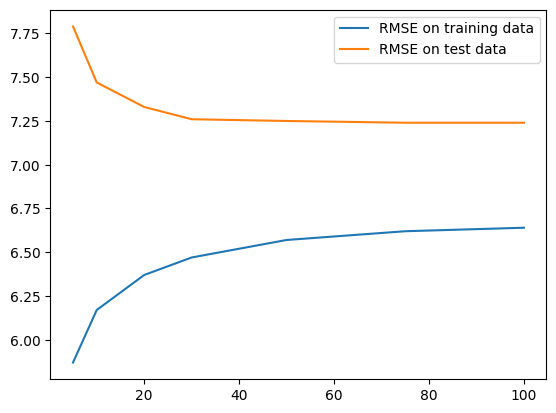

In [182]:
plt.plot(
    search_space,
    train_rmse_list,
    label="RMSE on training data"
)
plt.plot(
    search_space,
    test_rmse_list,
    label="RMSE on test data"
)
plt.legend()
plt.show()

It seems that the best option is to stop at around 30 neighbors.

Let's refit it and see the R^2.

In [183]:
reg = KNeighborsRegressor(
        n_neighbors=30
    )
reg.fit(X, y)
pred = reg.predict(X)
print(
    "R^2 is:", round(
        r2_score(y, pred), 3
        )
)

R^2 is: 0.295


In [184]:
print(
    "MSE of our model is:", round(
        mean_squared_error(y, pred), 3
        )
)
print(
    "MSE of mean imputation is:", round(
        mean_squared_error(y, [y.mean()]*len(y)), 3
        )
)

MSE of our model is: 44.289
MSE of mean imputation is: 62.843


Our model is slightly better than guessing. I guess we'll have to take it.

In [185]:
train_set_copy = train_set.reset_index(drop=True).copy()
train_set_copy["gender"] = train_set_copy["gender"].apply(lambda x: x=="Male")
train_set_copy["ever_married"] = train_set_copy["ever_married"].apply(lambda x: x=="Yes")
train_set_copy["smoking_status"] = train_set_copy["smoking_status"].map({"never smoked": 0, "formerly smoked": 1, "smokes": 2, "Unknown": 0})
train_set_copy = pd.get_dummies(
    data=train_set_copy, columns=["work_type", "Residence_type"]
)

for index, row in train_set_copy.iterrows():
    if pd.isna(row["bmi"]) or (row["bmi"]==0):
        train_set_copy.at[index, "bmi"] = reg.predict(
            train_set_copy.iloc[index,].to_frame().T.drop(columns="bmi")
        )

In [186]:
train_set["bmi"] = list(train_set_copy["bmi"].copy())
print("Missing values for bmi after imputation:", train_set["bmi"].isna().sum())

Missing values for bmi after imputation: 0


# Outliers

<Axes: xlabel='Count', ylabel='gender'>

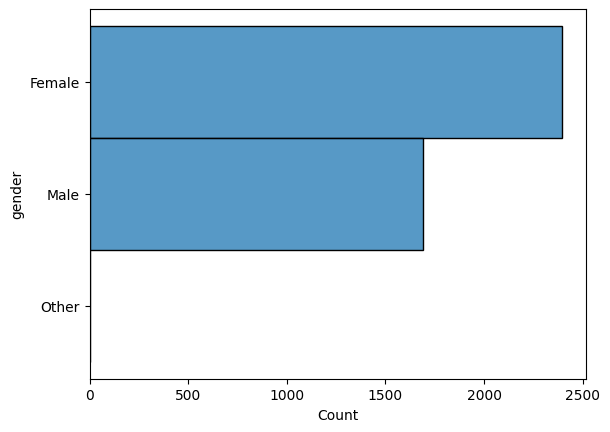

In [187]:
sns.histplot(
    y="gender",
    data=train_set
)

There are almost 1000 more female participants than males. We have to keep this in mind and possibly over/undersample

Also, there are very few participants with gender other. To prevent overfitting, we should drop these

In [188]:
print("Size before dropping")
print(train_set.value_counts("gender"))
train_set = train_set[train_set["gender"]!="Other"].copy()
print("Size after dropping")
print(train_set.value_counts("gender"))

Size before dropping
gender
Female    2395
Male      1692
Other        1
Name: count, dtype: int64
Size after dropping
gender
Female    2395
Male      1692
Name: count, dtype: int64


<Axes: xlabel='age', ylabel='Count'>

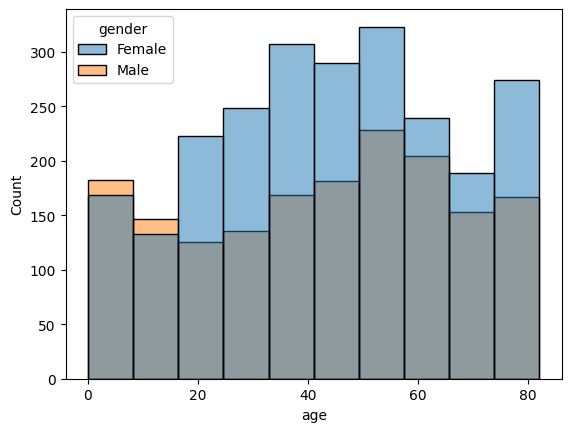

In [189]:
sns.histplot(
    data=train_set,
    x="age",
    hue="gender",
    bins=int(
        np.sqrt(
            len(train_set["age"].unique())
            )
    )
)

We can see that the two genders in this dataset have slightly different distributions.

We should keep that in mind when creating a model.

Also, there appear to be a lot of respondents in the highest age bin.

This could be because older participants are automatically put into the 80 year age bin.

In [190]:
train_set["hypertension"].value_counts()

hypertension
0    3690
1     397
Name: count, dtype: int64

<Axes: xlabel='hypertension', ylabel='age'>

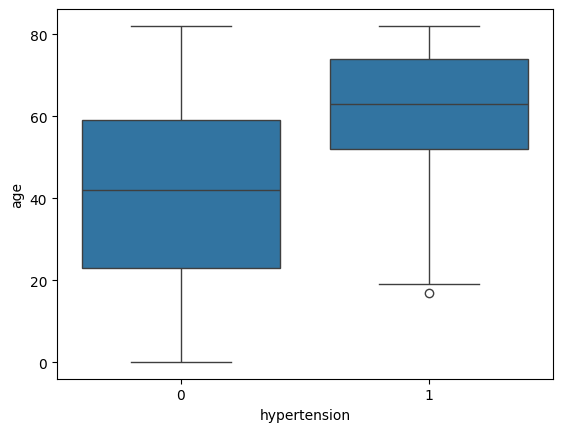

In [191]:
sns.boxplot(
    x="hypertension",
    y="age",
    data=train_set
)

Only some of the participants have hypertension.

It is also probably correlated with a higher age (participants below 20 years old are unlikely to have it).

Let's remove those outlying points.

In [192]:
train_set.loc[(train_set["age"]<20) & (train_set["hypertension"]==1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
62126,Female,19.0,1,0,No,Private,Rural,65.96,29.0,never smoked,0


In [193]:
train_set = train_set.loc[~(
    (train_set["age"]<20) & (train_set["hypertension"]==1)
    )].copy()

<Axes: xlabel='heart_disease', ylabel='age'>

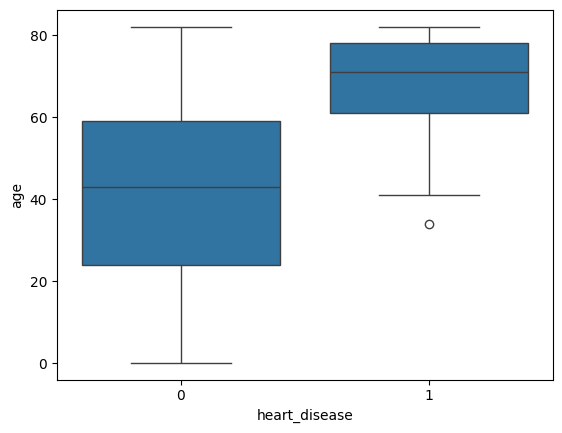

In [194]:
sns.boxplot(
    x="heart_disease",
    y="age",
    data=train_set
)

Heart disease is also highly correlated with age, though we see a few outliers where young people have it as well.

We should pay attention to these samples and take appropriate care.

<Axes: xlabel='gender', ylabel='ever_married'>

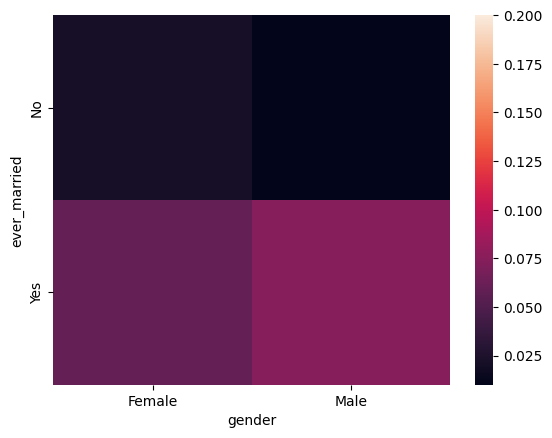

In [195]:
sns.heatmap(
    train_set.pivot_table(
        values="stroke",
        index="ever_married",
        columns="gender",
        aggfunc="mean"
    ),
    vmax=0.2
)

Married people are more likely to have a stroke, though this could be just correlated with age.

<Axes: xlabel='ever_married', ylabel='age'>

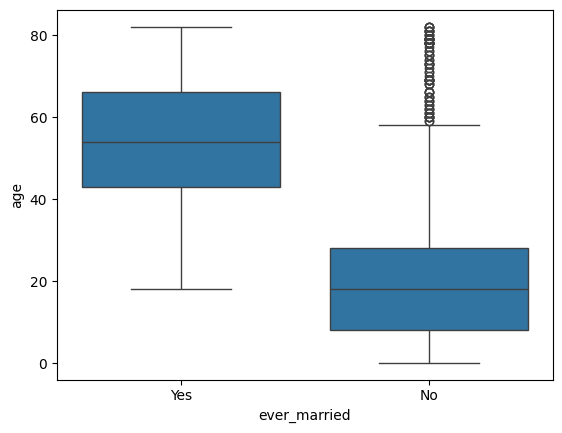

In [196]:
sns.boxplot(
    x="ever_married",
    y="age",
    data=train_set
)

This does seem to be the case.

In [197]:
train_set.loc[(train_set["age"]<40) & (train_set["heart_disease"]==1)].sort_values(by="age")

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
31091,Male,34.0,0,1,Yes,Private,Urban,106.23,29.33,formerly smoked,0


In [198]:
train_set = train_set.loc[~(
    (train_set["age"]<40) & (train_set["heart_disease"]==1)
    )].copy()

In [199]:
train_set["work_type"].value_counts()

work_type
Private          2328
Self-employed     667
children          554
Govt_job          522
Never_worked       13
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='work_type'>

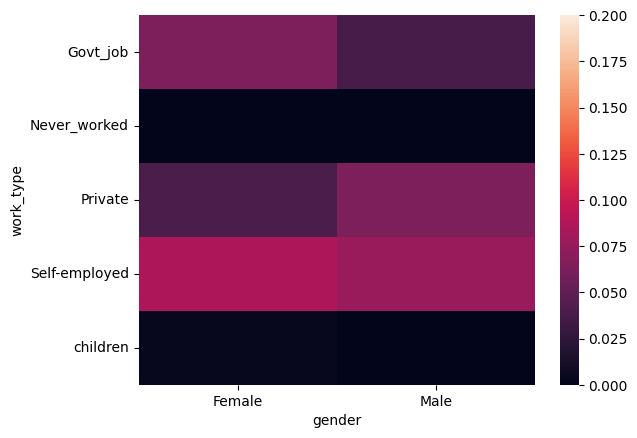

In [200]:
sns.heatmap(
    train_set.pivot_table(
        values="stroke",
        index="work_type",
        columns="gender",
        aggfunc="mean"
    ),
    vmax=0.2
)

We can see that self-employed people have a slightly larger chance of stroke (for both genders).

Those who are caring for children (or never worked, though that is just a small sample) are very unlikely to have a stroke.

Let's drop those who never worked from the dataset.

In [201]:
train_set = train_set.loc[train_set["work_type"]!="Never_worked"].copy()

In [202]:
train_set["Residence_type"].value_counts()

Residence_type
Urban    2058
Rural    2013
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='Residence_type'>

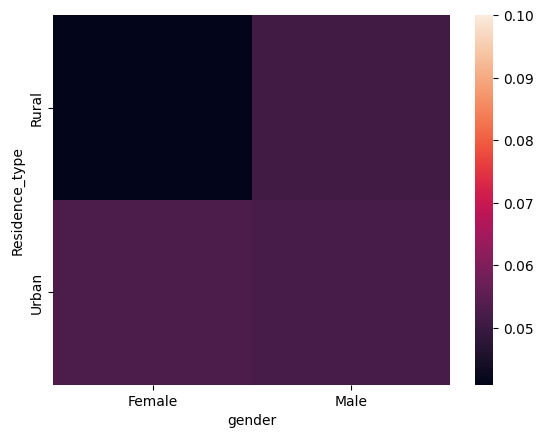

In [203]:
sns.heatmap(
    train_set.pivot_table(
        values="stroke",
        index="Residence_type",
        columns="gender",
        aggfunc="mean"
    ),
    vmax=0.1
)

We can see that males in urban areas have a slightly higher chance of stroke, but it's hardly a significant difference.

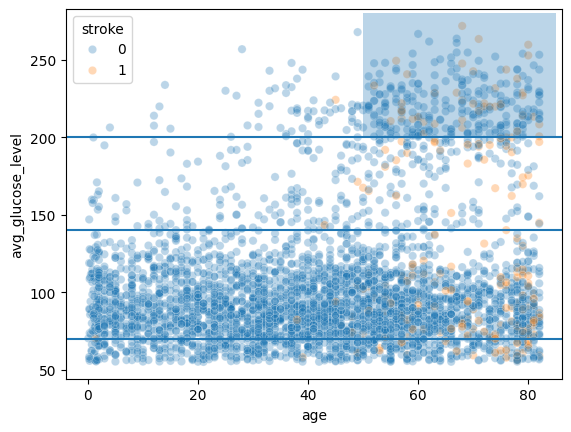

In [204]:
graph = sns.scatterplot(
    x="age",
    y="avg_glucose_level",
    hue="stroke",
    data=train_set,
    alpha=0.3
)
graph.axhline(70)
graph.axhline(140)
graph.axhline(200)
graph.add_patch(
    plt.Rectangle(
        (50, 200), 35, 80,
        alpha=0.3
        )
    )
plt.show()

ChatGPT told me, that the unit used is milligrams per deciliter (mg/Dl).

Values below 70 can indicate hypoglycemia for all ages (this can be caused by excessive insulin, prolonged fasting or rare tumors).

Normal values are between 70 and 100 (up to 140 if measured after eating).

Prediabetic levels are between 100 and 125 (up to 140-199 if measured after eating).

Diabetes are above 125 when fasting (higher than 200 after eating).


In [205]:
train_set["glucose_level_diagnosis"] = train_set["avg_glucose_level"].apply(
    lambda x: "hypoglycemia" if x<70
    else "non-diabetic" if x<140
    else "pre-diabetic" if x<200
    else "diabetic"
)

Let's do the same for the test set, since it doesn't introduce any leakage.

In [206]:
test_set["glucose_level_diagnosis"] = test_set["avg_glucose_level"].apply(
    lambda x: "hypoglycemia" if x<70
    else "non-diabetic" if x<140
    else "pre-diabetic" if x<200
    else "diabetic"
)

Continuing on to age, let's create bins to more easily visualize its effect on stroke probability.

It will be dropped later.

In [207]:
train_set["age_bin"] = train_set["age"].apply(lambda x: 0 if x<10 else int(str(x)[0]+"0"))

<Axes: xlabel='age_bin', ylabel='glucose_level_diagnosis'>

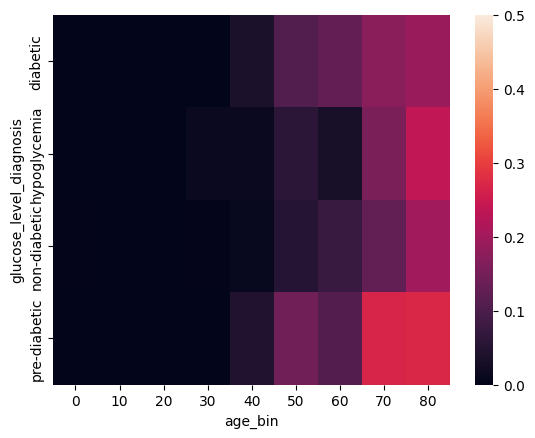

In [208]:
sns.heatmap(
    train_set.pivot_table(
        values="stroke",
        index="glucose_level_diagnosis",
        columns="age_bin",
        aggfunc="mean"
    ),
    vmax=0.5
)

We can see that the likelyhood of stroke increases with age, and also increased average glucose levels.

<Axes: xlabel='age', ylabel='bmi'>

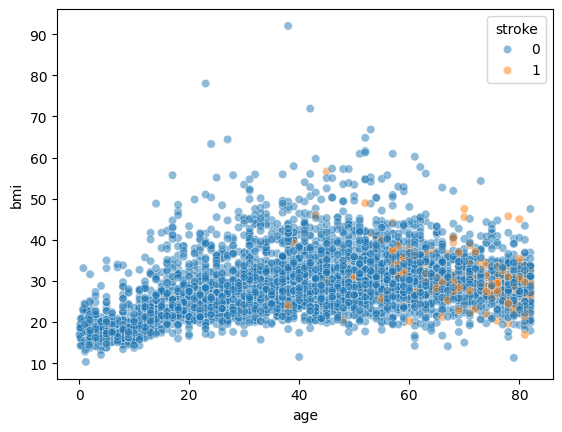

In [209]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="stroke",
    data=train_set,
    alpha=0.5
)

We can see that bmi is somewhat lower in children. We can also see a few outliers in bmi:

Those above 40 bmi are slightly unusual.

Those above 60 bmi are very rare.

Similarly, those under 10 bmi in children and 20 bmi in adults are unusual.

In [210]:
train_set_copy = train_set.copy()
avg_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(np.mean).to_dict()
q001_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(lambda x: np.quantile(x, 0.01)).to_dict()
q099_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(lambda x: np.quantile(x, 0.99)).to_dict()

/tmp/ipykernel_2100284/2096241472.py:2: FutureWarning: The provided callable <function mean at 0x7fc9bc0f8f70> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(np.mean).to_dict()


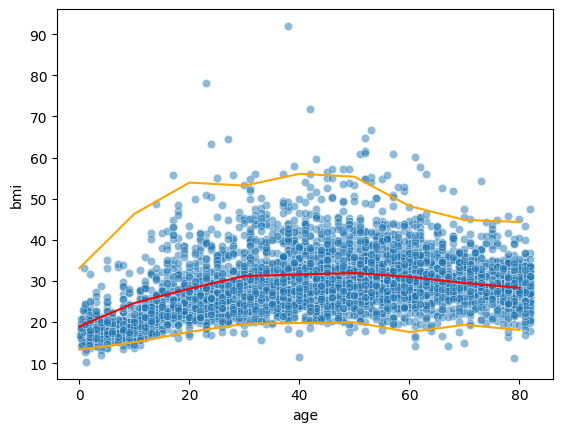

In [211]:
sns.scatterplot(
    x="age",
    y="bmi",
    # hue="stroke",
    data=train_set_copy,
    alpha=0.5
)
plt.plot(
    avg_bmi_by_age_bin.keys(), avg_bmi_by_age_bin.values(), color="red"
)
plt.plot(
    q001_bmi_by_age_bin.keys(), q001_bmi_by_age_bin.values(), color="orange"
)
plt.plot(
    q099_bmi_by_age_bin.keys(), q099_bmi_by_age_bin.values(), color="orange"
)
plt.show()

Hmm this doesn't isolate outliers very well, let's try a different method.

In [212]:
from sklearn.cluster import DBSCAN

X = train_set[["age", "bmi"]].copy()

clustering = DBSCAN(eps=4, min_samples=40) # EPS=5, MS=100
pred = clustering.fit_predict(X)

X["outlier"] = pred

<Axes: xlabel='age', ylabel='bmi'>

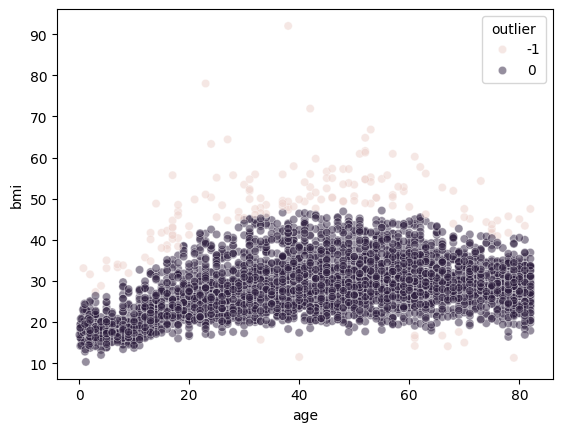

In [213]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="outlier",
    data=X,
    alpha=0.5
)

In [214]:
X["outlier"].value_counts()

outlier
 0    3917
-1     154
Name: count, dtype: int64

In [215]:
train_set = train_set.loc[X["outlier"]!=-1].copy()

Let's repeat it.

In [216]:
train_set_copy = train_set.copy()
avg_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(np.mean).to_dict()
q001_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(lambda x: np.quantile(x, 0.01)).to_dict()
q099_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(lambda x: np.quantile(x, 0.99)).to_dict()

/tmp/ipykernel_2100284/2096241472.py:2: FutureWarning: The provided callable <function mean at 0x7fc9bc0f8f70> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  avg_bmi_by_age_bin = train_set_copy.groupby("age_bin")["bmi"].aggregate(np.mean).to_dict()


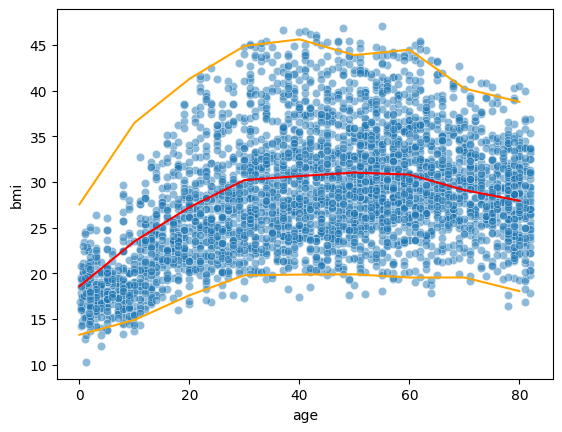

In [217]:
sns.scatterplot(
    x="age",
    y="bmi",
    # hue="stroke",
    data=train_set_copy,
    alpha=0.5
)
plt.plot(
    avg_bmi_by_age_bin.keys(), avg_bmi_by_age_bin.values(), color="red"
)
plt.plot(
    q001_bmi_by_age_bin.keys(), q001_bmi_by_age_bin.values(), color="orange"
)
plt.plot(
    q099_bmi_by_age_bin.keys(), q099_bmi_by_age_bin.values(), color="orange"
)
plt.show()

We will remove the values below the lower bound (because there is more naturally more variance in overweight bmi than in underweight bmi.)

In [218]:
print("Nrows before:", train_set.shape[0])
train_set = train_set_copy.loc[
    train_set_copy["bmi"] > train_set_copy["age_bin"].map(q001_bmi_by_age_bin)
].copy()
print("Nrows after:", train_set.shape[0])

Nrows before: 3917
Nrows after: 3873


In [219]:
train_set["smoking_status"].value_counts()

smoking_status
never smoked       1412
Unknown            1188
formerly smoked     674
smokes              599
Name: count, dtype: int64

<Axes: xlabel='age_bin', ylabel='smoking_status'>

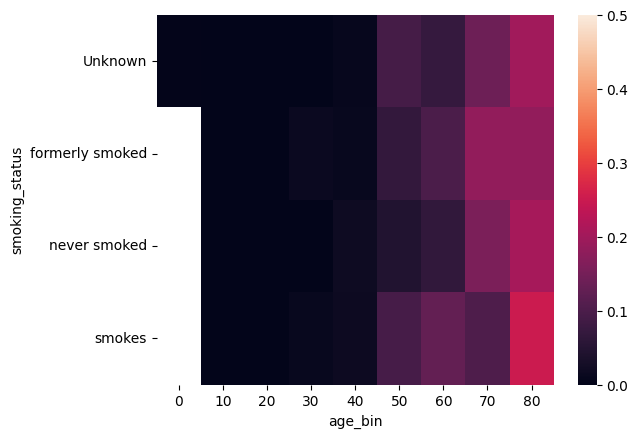

In [220]:
sns.heatmap(
    train_set.pivot_table(
        values="stroke",
        index="smoking_status",
        columns="age_bin",
        aggfunc="mean"
    ),
    vmax=0.5
)

We can see that smoking significantly increases chance of stroke (especially with rising age).

Not smoking means lower probability of stroke in ages 40-60.

<Axes: xlabel='age', ylabel='bmi'>

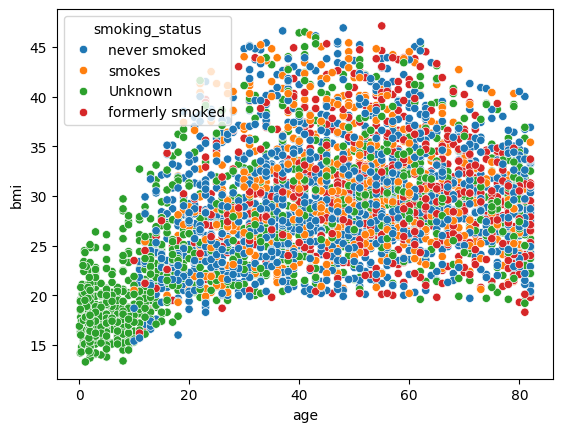

In [221]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="smoking_status",
    data=train_set
)

We can set smoking status of those under age of 15 to never smoked.

As for the rest, we can do a coin toss.

In [222]:
train_set.loc[train_set["age"]<=15]["smoking_status"].value_counts()

smoking_status
Unknown            483
never smoked        58
formerly smoked     18
smokes               2
Name: count, dtype: int64

In [223]:
train_set.loc[train_set["age"]>15]["smoking_status"].value_counts()

smoking_status
never smoked       1354
Unknown             705
formerly smoked     656
smokes              597
Name: count, dtype: int64

In [224]:
import random

for i in list(train_set.index):
    smoking_status = train_set.at[i, "smoking_status"]
    age = train_set.at[i, "age"]
    if smoking_status == "Unknown":
        if age<=15:
            train_set.at[i, "smoking_status"] = "never smoked"
        else:
            train_set.at[i, "smoking_status"] = random.choices(
        population=["never smoked", "formerly smoked", "smokes"], 
        weights=[0.52, 0.25, 0.23]
    )[0]

<Axes: xlabel='age', ylabel='bmi'>

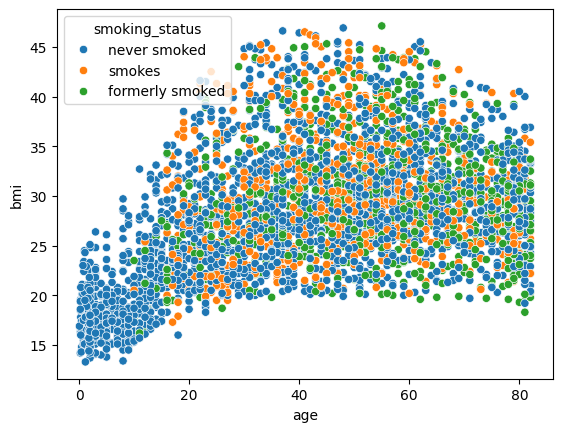

In [225]:
sns.scatterplot(
    x="age",
    y="bmi",
    hue="smoking_status",
    data=train_set
)

This is looking much better.

Let's also change it for the test set, since we could have problems if we used the most common class.

We will use the weights that were trained on the train set.

In [226]:
for i in list(test_set.index):
    smoking_status = test_set.at[i, "smoking_status"]
    age = test_set.at[i, "age"]
    if smoking_status == "Unknown":
        if age<=15:
            test_set.at[i, "smoking_status"] = "never smoked"
        else:
            test_set.at[i, "smoking_status"] = random.choices(
        population=["never smoked", "formerly smoked", "smokes"], 
        weights=[0.52, 0.25, 0.23]
    )[0]

We have managed to fill in missing values and remove some of the outliers in the train set.

In the test set, we have left NA values in BMI (since imputing them could introduce leakage) and imputed missing status for smokers using weights from the train set.

In [227]:
train_set.pop("age_bin")
train_set.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3873.000000,3873.000000,3873.000000,3873.00000,3873.00000,3873.000000
mean,43.555414,0.095791,0.056287,105.99354,28.39088,0.049574
std,22.631904,0.294343,0.230505,44.87258,6.52450,0.217091
min,0.080000,0.000000,0.000000,55.12000,13.30000,0.000000
25%,26.000000,0.000000,0.000000,77.23000,23.80000,0.000000
50%,45.000000,0.000000,0.000000,91.85000,28.10000,0.000000
75%,61.000000,0.000000,0.000000,114.02000,32.50000,0.000000
max,82.000000,1.000000,1.000000,271.74000,47.10000,1.000000


We will now correctly specify data types.

In [228]:
train_set["hypertension"] = train_set["hypertension"].astype(bool)
train_set["heart_disease"] = train_set["heart_disease"].astype(bool)
train_set["ever_married"] = train_set["ever_married"].map({"Yes": True, "No": False})
train_set["stroke"] = train_set["stroke"].astype(bool)

test_set["hypertension"] = test_set["hypertension"].astype(bool)
test_set["heart_disease"] = test_set["heart_disease"].astype(bool)
test_set["ever_married"] = test_set["ever_married"].map({"Yes": True, "No": False})
test_set["stroke"] = test_set["stroke"].astype(bool)

Let's export both train and set sets.

In [229]:
train_set.to_csv("data_train.csv")
test_set.to_csv("data_test.csv")

# Optional: mitigate class imbalance in training data

In [234]:
from imblearn.over_sampling import SMOTENC

X = train_set.copy()
y = X.pop("stroke")

# Apply SMOTE
sm = SMOTENC(
    categorical_features=["gender", "work_type", "Residence_type", "smoking_status", "glucose_level_diagnosis"],
    random_state=42
)
X_res, y_res = sm.fit_resample(X, y)

X_res["stroke"] = y_res
train_set_res = X_res.copy()

In [246]:
train_set_res.to_csv("data_train_balanced.csv")